In [1]:
pip install torch torch-geometric  # Install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & preprocessing imports
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# PyTorch and PyTorch Geometric imports
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Pandas display option
pd.set_option('display.max_columns', 100)


In [3]:
# Mount Google Drive
from google.colab import drive

# Mounting Google Drive to access files
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# File path for the dataset stored in Google Drive
url1 = '/content/drive/MyDrive/Mimic_finale_2024.csv'


In [5]:
# Read the dataset from the CSV file and load it into a DataFrame
Mimic_df = pd.read_csv(url1)


In [6]:
# Set the index of Mimic_df to 'SUBJECT_ID'
Mimic_df.set_index('SUBJECT_ID', inplace=True)

In [7]:
# Create a copy of Mimic_df
copy_mimic = Mimic_df.copy()

In [8]:
# Check the shape of the copy_mimic DataFrame to understand its dimensions (rows, columns)
copy_mimic.shape


(25955, 42)

In [9]:
# Check for duplicates and missing values
print('Missing data:\n', copy_mimic.isna().sum())
print('\n')
print('Duplicates:', copy_mimic.duplicated().sum())

Missing data:
 HADM_ID                  0
ICUSTAY_ID               0
ADMISSION_TYPE           0
ADMISSION_LOCATION       0
GENDER                   0
MARITAL_STATUS           0
RELIGION                 0
ETHNICITY                0
LANGUAGE                 0
AGE PATIENT              0
INSURANCE                0
DISCHARGE_LOCATION       0
FIRST_CAREUNIT           0
LAST_CAREUNIT            0
FIRST_WARDID             0
LAST_WARDID              0
DIAGNOSIS                0
HOSPITAL_EXPIRE_FLAG     0
HAS_CHARTEVENTS_DATA     0
EXPIRE_FLAG              0
CD9_CODE_DIAGNOSIS       0
LONG_TITLE_DIAGNOSIS     0
CD9_CODE_PROCEDURES      0
LONG_TITLE_PROCEDURES    0
FORMULARY_DRUG_CD        0
PROD_STRENGTH            0
DOSE_VAL_RX              0
FORM_VAL_DISP            0
INTIME                   0
OUTTIME                  0
LOS                      0
SPEC_ITEMID              0
SPEC_TYPE_DESC           0
ORG_ITEMID               0
ORG_NAME                 0
ISOLATE_NUM              0
AB_ITEMID    

In [10]:
# List of column names to be removed
colonnes_a_supprimer = ['HADM_ID', 'ICUSTAY_ID', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME']

# Remove multiple columns simultaneously from the copy_mimic DataFrame
copy_mimic = copy_mimic.drop(columns=colonnes_a_supprimer)


In [11]:
# Display the range of values in the 'AGE PATIENT' column
print("Range of values in 'Age' column:", copy_mimic['AGE PATIENT'].min(), "-", copy_mimic['AGE PATIENT'].max())

# Calculate the maximum and minimum ages
max_age = copy_mimic['AGE PATIENT'].max()
min_age = copy_mimic['AGE PATIENT'].min()

# Print the maximum and minimum ages
print(f"Max age: {max_age}")
print(f"Min age: {min_age}")


Range of values in 'Age' column: 15 - 146
Max age: 146
Min age: 15


In [12]:
# Set an upper limit for age
age_upper_limit = 90

In [13]:
# Correct any values beyond the reasonable limits
copy_mimic.loc[copy_mimic['AGE PATIENT']> age_upper_limit, 'AGE PATIENT'] = age_upper_limit

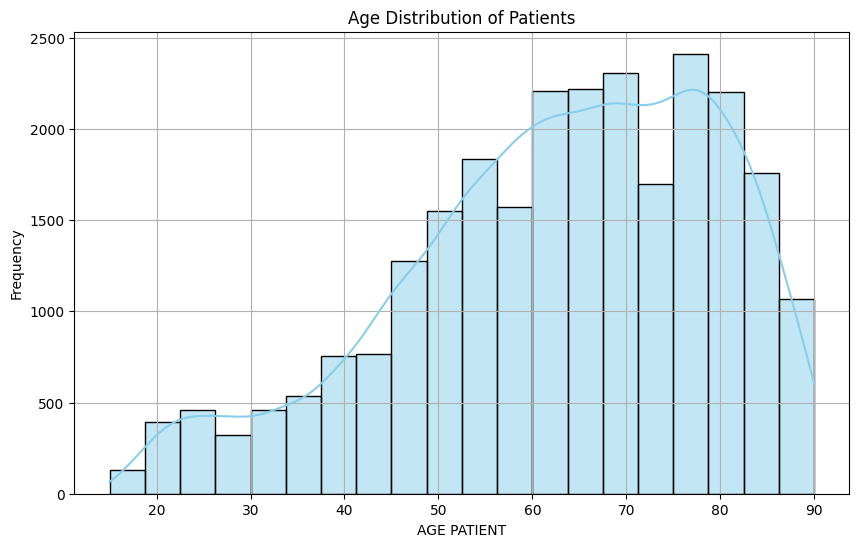

In [14]:
# Visualization 1: Histogram of Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=copy_mimic, x='AGE PATIENT', bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('AGE PATIENT')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

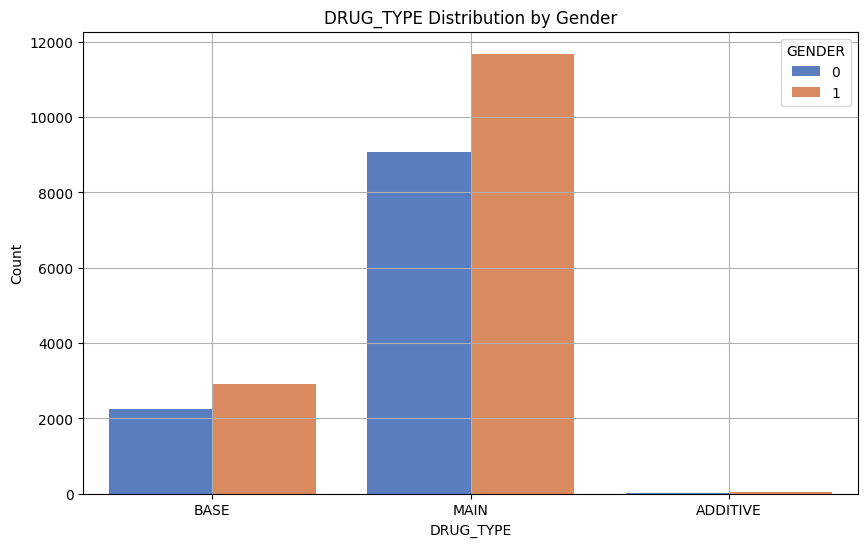

In [15]:
# Visualization 2: Bar Chart of Drug Distribution by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=Mimic_df, x='DRUG_TYPE', hue='GENDER', palette='muted')
plt.title('DRUG_TYPE Distribution by Gender')
plt.xlabel('DRUG_TYPE')
plt.ylabel('Count')
plt.legend(title='GENDER')
plt.grid(True)
plt.show()

In [16]:
copy_mimic.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,GENDER,MARITAL_STATUS,RELIGION,ETHNICITY,LANGUAGE,AGE PATIENT,INSURANCE,DISCHARGE_LOCATION,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,EXPIRE_FLAG,CD9_CODE_DIAGNOSIS,LONG_TITLE_DIAGNOSIS,CD9_CODE_PROCEDURES,LONG_TITLE_PROCEDURES,FORMULARY_DRUG_CD,PROD_STRENGTH,DOSE_VAL_RX,FORM_VAL_DISP,LOS,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,INTERPRETATION,DILUTION_VALUE,AB_NAME,DRUG_TYPE,DRUG
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,ELECTIVE,PHYS REFERRAL/NORMAL DELI,1,MARRIED,CATHOLIC,WHITE,ENGL,71,Medicare,HOME HEALTH CARE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0,41401,Coronary atherosclerosis of native coronary ar...,151,Excision of lesion or tissue of cerebral meninges,SW50,50 mL Bag,50,1,1.2641,70064.0,STOOL,80075.733462,STAPH AUREUS COAG +,1.065087,90015.728205,S,6.688087,GENTAMICIN,BASE,SW
25,EMERGENCY,EMERGENCY ROOM ADMIT,1,MARRIED,UNOBTAINABLE,WHITE,ENGL,59,Private,HOME,ACUTE CORONARY SYNDROME,0,1,0,41071,"Subendocardial infarction, initial episode of ...",3607,Insertion of drug-eluting coronary artery sten...,HEPAPREMIX,"25,000 unit Premix Bag","25,000",1,3.5466,70012.0,BLOOD CULTURE,80075.733462,STAPH AUREUS COAG +,1.065087,90015.728205,S,6.688087,GENTAMICIN,MAIN,Heparin Sodium
26,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,1,SINGLE,CATHOLIC,UNKNOWN/NOT SPECIFIED,ENGL,72,Medicare,HOME,V-TACH,0,1,1,41401,Coronary atherosclerosis of native coronary ar...,3794,Implantation or replacement of automatic cardi...,DOFE250,250MCG CAP,250,1,2.1407,70012.0,BLOOD CULTURE,80075.733462,STAPH AUREUS COAG +,1.065087,90015.728205,S,6.688087,GENTAMICIN,MAIN,Dofetilide
31,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,1,MARRIED,CATHOLIC,WHITE,ENGL,73,Medicare,DEAD/EXPIRED,STATUS EPILEPTICUS,1,1,1,486,"Pneumonia, organism unspecified",114,Open biopsy of brain,PHEN130I,130mg/mL Vial,400,3.08,7.9379,70012.0,BLOOD CULTURE,80075.733462,STAPH AUREUS COAG +,1.065087,90015.728205,S,6.688087,GENTAMICIN,MAIN,Phenobarbital Sodium
34,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,1,MARRIED,CATHOLIC,WHITE,ENGL,26,Medicare,HOME,CHEST PAIN\CATH,0,1,1,4254,Other primary cardiomyopathies,3723,Combined right and left heart cardiac catheter...,D5W1000,1000mL Bag,1000,1000,0.7198,70091.0,MRSA SCREEN,80075.733462,STAPH AUREUS COAG +,1.065087,90015.728205,S,6.688087,GENTAMICIN,BASE,D5W


In [17]:
# Check for inconsistent values in categorical columns
print("Unique values in 'MARITAL_STATUS column:", copy_mimic['MARITAL_STATUS'].unique())

Unique values in 'MARITAL_STATUS column: ['MARRIED' 'SINGLE' 'WIDOWED' 'DIVORCED' 'SEPARATED' 'UNKNOWN (DEFAULT)'
 'LIFE PARTNER']


In [18]:
# Assuming 'copy_mimic' is your DataFrame
print("Unique values in 'ADMISSION_TYPE' column:", copy_mimic['ADMISSION_TYPE'].unique())


Unique values in 'ADMISSION_TYPE' column: ['ELECTIVE' 'EMERGENCY' 'URGENT']


In [19]:
# Filtrer le DataFrame pour exclure les lignes avec '** INFO NOT AVAILABLE **'
copy_mimic = copy_mimic[copy_mimic['ADMISSION_LOCATION'] != '** INFO NOT AVAILABLE **']

In [20]:
# Imprimer les valeurs uniques de la colonne 'ETHNICITY'
print("Unique values in 'RELIGION' column:", copy_mimic['ETHNICITY'].unique())

Unique values in 'RELIGION' column: ['WHITE' 'UNKNOWN/NOT SPECIFIED' 'MULTI RACE ETHNICITY'
 'PATIENT DECLINED TO ANSWER' 'BLACK/AFRICAN AMERICAN' 'ASIAN'
 'HISPANIC OR LATINO' 'HISPANIC/LATINO - GUATEMALAN' 'OTHER'
 'ASIAN - VIETNAMESE' 'HISPANIC/LATINO - PUERTO RICAN'
 'ASIAN - ASIAN INDIAN' 'HISPANIC/LATINO - DOMINICAN' 'UNABLE TO OBTAIN'
 'WHITE - RUSSIAN' 'ASIAN - CHINESE' 'AMERICAN INDIAN/ALASKA NATIVE'
 'HISPANIC/LATINO - SALVADORAN' 'BLACK/HAITIAN' 'WHITE - EASTERN EUROPEAN'
 'ASIAN - FILIPINO' 'ASIAN - CAMBODIAN' 'BLACK/CAPE VERDEAN'
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' 'WHITE - BRAZILIAN'
 'HISPANIC/LATINO - COLOMBIAN' 'PORTUGUESE' 'WHITE - OTHER EUROPEAN'
 'HISPANIC/LATINO - HONDURAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'MIDDLE EASTERN' 'BLACK/AFRICAN' 'ASIAN - OTHER'
 'HISPANIC/LATINO - CUBAN' 'CARIBBEAN ISLAND' 'HISPANIC/LATINO - MEXICAN'
 'SOUTH AMERICAN' 'ASIAN - KOREAN' 'ASIAN - THAI'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'
 'ASIAN 

In [21]:
# Liste des valeurs à exclure de la colonne "region"
excluded_values = ['UNKNOWN/NOT SPECIFIED']

# Filtrer le DataFrame pour exclure les lignes avec les valeurs spécifiées
copy_mimic = copy_mimic[~copy_mimic['ETHNICITY'].isin(excluded_values)]

In [22]:
copy_mimic .shape

(24489, 34)

In [23]:
 print("Unique values in 'RELIGION' column:", copy_mimic['LANGUAGE'].unique())


Unique values in 'RELIGION' column: ['ENGL' 'PORT' 'MAND' 'CANT' 'SPAN' 'RUSS' '*MAN' 'ITAL' 'HAIT' 'GREE'
 'CAMB' 'PTUN' '*CHI' 'POLI' 'LAOT' '*URD' '*BUR' 'VIET' 'CAPE' '*BEN'
 'HIND' 'AMER' '*TOY' '*HUN' 'ALBA' 'THAI' 'JAPA' 'FREN' '*PHI' 'KORE'
 'ARAB' 'PERS' '*FUL' 'SOMA' '* BE' '*CAN' 'ETHI' '*TOI' '*BOS' '*BUL'
 '*ARM' '*TEL' '*YID' '*IBO' '**TO' '*AMH' 'TAGA' '* FU' '*MOR' '*ARA'
 '*YOR' '*GUJ' '*DUT' '*KHM' '*CDI' '** T' '*NEP' 'URDU' '*FIL' '*PER'
 '**SH' '*TAM']


In [24]:
 print("Unique values in 'DIAGNOSIS' column:", copy_mimic['DIAGNOSIS'].unique())

Unique values in 'DIAGNOSIS' column: ['CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA'
 'ACUTE CORONARY SYNDROME' 'STATUS EPILEPTICUS' ... 'R/O METASTASIS'
 'GASTROPARESIS\\PLACEMENT OF G-TUBE **REMOTE WEST**/SDA' 'JOINT EFFUSION']


In [25]:
# Remplacer '\\' par un espace dans la colonne "DIAGNOSIS"
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'**', ' ')
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'\\', ' ')
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'/', ' ')
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'-', ' ')
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r';', ' ')
copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'...', ' ')

<ipython-input-25-e7f828fdf3b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'**', ' ')
<ipython-input-25-e7f828fdf3b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_mimic['DIAGNOSIS'] = copy_mimic['DIAGNOSIS'].str.replace(r'\\', ' ')
<ipython-input-25-e7f828fdf3b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [26]:
# Remplacer '\\' par un espace dans la colonne "LONG_TITLE_DIAGNOSIS"
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r'(', ' ')
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r')', ' ')
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r']', ' ')
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r'[', ' ')
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r',', ' ')
copy_mimic['LONG_TITLE_DIAGNOSIS'] = copy_mimic['LONG_TITLE_DIAGNOSIS'].str.replace(r'.', ' ')

In [27]:
# Remplacer '\\' par un espace dans la colonne "LONG_TITLE_PROCEDURES"
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r'(', ' ')
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r')', ' ')
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r']', ' ')
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r'[', ' ')
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r',', ' ')
copy_mimic['LONG_TITLE_PROCEDURES'] = copy_mimic['LONG_TITLE_PROCEDURES'].str.replace(r'.', ' ')

In [28]:

# Sélection de 6185 hommes et 7236 femmes
df_men = copy_mimic[copy_mimic['GENDER'] == 0]
df_women = copy_mimic[copy_mimic['GENDER'] == 1]
# Combiner les échantillons
# copy_mimic = pd.concat([df_men, df_women])


In [29]:
# Identifier les colonnes avec des valeurs nulles
columns_with_nulls = copy_mimic.columns[copy_mimic.isnull().any()]
columns_with_nulls

Index([], dtype='object')

data representaion

# Diviser le DataFrame en features et target

In [30]:
# Diviser le DataFrame en features et target
features= copy_mimic.drop(columns=['DRUG'])  # Features
Target= copy_mimic['DRUG']   # Target variable
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# PIPELINE DE PRÉTRAITEMENT DES DONNÉES NUMÉRIQUES
# Enregistrer la liste des noms de colonnes
num_cols = features.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = MinMaxScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe



Numeric Columns: Index(['GENDER', 'AGE PATIENT', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
       'EXPIRE_FLAG', 'CD9_CODE_PROCEDURES', 'LOS', 'SPEC_ITEMID',
       'ORG_ITEMID', 'ISOLATE_NUM', 'AB_ITEMID', 'DILUTION_VALUE'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler())])

In [32]:
# Créer un tuple numérique pour ColumnTransformer
num_tuple = (' numeric', num_pipe, num_cols)
num_tuple


(' numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('minmaxscaler', MinMaxScaler())]),
 Index(['GENDER', 'AGE PATIENT', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
        'EXPIRE_FLAG', 'CD9_CODE_PROCEDURES', 'LOS', 'SPEC_ITEMID',
        'ORG_ITEMID', 'ISOLATE_NUM', 'AB_ITEMID', 'DILUTION_VALUE'],
       dtype='object'))

In [33]:
# PIPELINE DE PRÉTRAITEMENT POUR LES DONNÉES UNIQUEMENT CODÉES À CHAUD
# Enregistrer la liste des noms de colonnes
ohe_cols = features.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'MARITAL_STATUS', 'RELIGION',
       'ETHNICITY', 'LANGUAGE', 'INSURANCE', 'DISCHARGE_LOCATION', 'DIAGNOSIS',
       'CD9_CODE_DIAGNOSIS', 'LONG_TITLE_DIAGNOSIS', 'LONG_TITLE_PROCEDURES',
       'FORMULARY_DRUG_CD', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'FORM_VAL_DISP',
       'SPEC_TYPE_DESC', 'ORG_NAME', 'INTERPRETATION', 'AB_NAME', 'DRUG_TYPE'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [34]:
# Making a ohe_tuple for ColumnTransformer

ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'MARITAL_STATUS', 'RELIGION',
        'ETHNICITY', 'LANGUAGE', 'INSURANCE', 'DISCHARGE_LOCATION', 'DIAGNOSIS',
        'CD9_CODE_DIAGNOSIS', 'LONG_TITLE_DIAGNOSIS', 'LONG_TITLE_PROCEDURES',
        'FORMULARY_DRUG_CD', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'FORM_VAL_DISP',
        'SPEC_TYPE_DESC', 'ORG_NAME', 'INTERPRETATION', 'AB_NAME', 'DRUG_TYPE'],
       dtype='object'))

In [35]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)

# Ajuster les données d'entraînement
col_transformer.fit(features)

ColumnTransformer(transformers=[(' numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['GENDER', 'AGE PATIENT', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
       'EXPIRE_FLAG', 'CD9_CODE_PROCEDURES', 'LOS', 'SPEC_ITEMID',
       'ORG_ITEMID', 'ISOLATE_NUM', 'AB_ITEMID', 'DILUTION_VALUE'],
      dtype='object')),
                                (...
                                 Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'MARITAL_STATUS', 'RELIGION',
       'ETHNICITY', 'LANGUAGE', 'INSURANCE', 'DISCHARGE_LOCATION', 'DIAGNOSIS',
       'CD9_CODE_DIAGNOSIS', 'LONG_TITLE_DIAGNOSIS', 'LONG_TITLE_PROCEDURES',
       'FORMULARY_DRUG_CD', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'FORM_VAL_DISP',
       'SPEC_TYPE_DESC', 'ORG_NAME', 'INTERPRETATION', 'AB_NAME', 'DRUG_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [36]:
# Transformer les données d'entraînement
X_train_processed_demo = col_transformer.transform(features)


In [37]:
# Récupérer les noms des colonnes transformées
# Pour les colonnes numériques
num_feature_names = num_cols

# Pour les colonnes catégoriques après OneHotEncoding
ohe_feature_names = col_transformer.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names_out(ohe_cols)

# Combiner les noms des colonnes transformées
columns_transformed = list(num_feature_names) + list(ohe_feature_names)

# Conversion des résultats en DataFrame pour un affichage plus lisible
features_processed_demo_df = pd.DataFrame(X_train_processed_demo, columns=columns_transformed)



In [38]:
features_processed_demo_df.head()

,GENDER,AGE PATIENT,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,EXPIRE_FLAG,CD9_CODE_PROCEDURES,LOS,SPEC_ITEMID,ORG_ITEMID,ISOLATE_NUM,AB_ITEMID,DILUTION_VALUE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,...,ORG_NAME_STREPTOCOCCUS ANGINOSUS,ORG_NAME_STREPTOCOCCUS ANGINOSUS (MILLERI) GROUP,ORG_NAME_STREPTOCOCCUS BOVIS,ORG_NAME_STREPTOCOCCUS MILLERI GROUP,ORG_NAME_STREPTOCOCCUS MITIS,ORG_NAME_STREPTOCOCCUS PNEUMONIAE,ORG_NAME_STREPTOCOCCUS SPECIES,ORG_NAME_STREPTOCOCCUS VESTIBULARIS,ORG_NAME_VEILLONELLA SPECIES,ORG_NAME_VIBRIO SPECIES,ORG_NAME_VIRIDANS STREPTOCOCCI,ORG_NAME_VIRUS,ORG_NAME_YEAST,"ORG_NAME_YEAST, PRESUMPTIVELY NOT C. ALBICANS",INTERPRETATION_I,INTERPRETATION_P,INTERPRETATION_R,INTERPRETATION_S,AB_NAME_AMIKACIN,AB_NAME_AMPICILLIN,AB_NAME_AMPICILLIN/SULBACTAM,AB_NAME_CEFAZOLIN,AB_NAME_CEFEPIME,AB_NAME_CEFTAZIDIME,AB_NAME_CEFTRIAXONE,AB_NAME_CEFUROXIME,AB_NAME_CHLORAMPHENICOL,AB_NAME_CIPROFLOXACIN,AB_NAME_CLINDAMYCIN,AB_NAME_DAPTOMYCIN,AB_NAME_ERYTHROMYCIN,AB_NAME_GENTAMICIN,AB_NAME_IMIPENEM,AB_NAME_LEVOFLOXACIN,AB_NAME_LINEZOLID,AB_NAME_MEROPENEM,AB_NAME_NITROFURANTOIN,AB_NAME_OXACILLIN,AB_NAME_PENICILLIN,AB_NAME_PENICILLIN G,AB_NAME_PIPERACILLIN,AB_NAME_PIPERACILLIN/TAZO,AB_NAME_RIFAMPIN,AB_NAME_TETRACYCLINE,AB_NAME_TOBRAMYCIN,AB_NAME_TRIMETHOPRIM/SULFA,AB_NAME_VANCOMYCIN,DRUG_TYPE_ADDITIVE,DRUG_TYPE_BASE,DRUG_TYPE_MAIN
0,1.0,0.746667,0.0,1.0,0.0,0.014121,0.008212,0.681319,0.242544,0.021696,0.473386,0.026125,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.586667,0.0,1.0,0.0,0.360240,0.023040,0.109890,0.242544,0.021696,0.473386,0.026125,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.773333,1.0,1.0,1.0,0.010416,0.051568,0.109890,0.242544,0.021696,0.473386,0.026125,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.146667,0.0,1.0,1.0,0.371858,0.004676,0.978022,0.242544,0.021696,0.473386,0.026125,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [39]:
# Sélectionner 200 patients aléatoires
features_processed_demo_df1=features_processed_demo_df.sample(n=200, random_state=1)


In [40]:
features_processed_demo_df1.shape

(200, 13702)

In [41]:
# Convert DataFrame to NumPy array
features_matrix =features_processed_demo_df1.to_numpy()

In [42]:
 #Convertir la feature matrix en tensor
features_tensor= torch.tensor(features_matrix, dtype=torch.float32)
features_tensor

tensor([[0.0000, 0.8667, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.4800, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [1.0000, 0.7067, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.0000, 0.7867, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [1.0000, 0.3600, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [1.0000, 0.6000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

In [43]:
# Convertir feature_matrix en tableau NumPy
feature_matrix_np = features_tensor.detach().numpy()

# Calculer la matrice de similarité cosinus
similarity_matrix_cosine = cosine_similarity(feature_matrix_np)

print(similarity_matrix_cosine)


[[1.0000001  0.32679445 0.46842426 ... 0.38237    0.34780058 0.32155037]
 [0.32679445 1.0000001  0.37263125 ... 0.5016519  0.55972373 0.43751305]
 [0.46842426 0.37263125 1.0000002  ... 0.4538768  0.5235298  0.41042304]
 ...
 [0.38237    0.5016519  0.4538768  ... 0.99999994 0.4892447  0.41212505]
 [0.34780058 0.55972373 0.5235298  ... 0.4892447  0.9999999  0.42284825]
 [0.32155037 0.43751305 0.41042304 ... 0.41212505 0.42284825 1.0000001 ]]


In [44]:
similarity_matrix_cosine.shape

(200, 200)

In [45]:
# Convertir la matrice de similarité cosinus en un tenseur PyTorch
similarity_tensor_cosine = torch.tensor(similarity_matrix_cosine, dtype=torch.float32)

In [46]:
similarity_tensor_cosine.shape

torch.Size([200, 200])

Pour entraîner un graphe convolutionnel (GCN) et prédire une matrice d'embeddings à partir d'une matrice de caractéristiques (feature Matrix) et d'une matrice de similarité (adjacency Matrix), il est essentiel de diviser les données en ensembles d' entraînement et de validation.

Epoch: 1, Train Loss: 0.0018, Val Loss: 0.0018
Epoch: 2, Train Loss: 0.0018, Val Loss: 0.0018
Epoch: 3, Train Loss: 0.0017, Val Loss: 0.0017
Epoch: 4, Train Loss: 0.0017, Val Loss: 0.0017
Epoch: 5, Train Loss: 0.0017, Val Loss: 0.0017
Epoch: 6, Train Loss: 0.0017, Val Loss: 0.0017
Epoch: 7, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 8, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 9, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 10, Train Loss: 0.0016, Val Loss: 0.0016
Checkpoint saved at epoch 10
Epoch: 11, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 12, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 13, Train Loss: 0.0016, Val Loss: 0.0016
Epoch: 14, Train Loss: 0.0015, Val Loss: 0.0016
Epoch: 15, Train Loss: 0.0015, Val Loss: 0.0015
Epoch: 16, Train Loss: 0.0015, Val Loss: 0.0015
Epoch: 17, Train Loss: 0.0015, Val Loss: 0.0015
Epoch: 18, Train Loss: 0.0015, Val Loss: 0.0015
Epoch: 19, Train Loss: 0.0015, Val Loss: 0.0015
Epoch: 20, Train Loss: 0.0015, Val Loss: 0.0015
Checkpoint saved at 

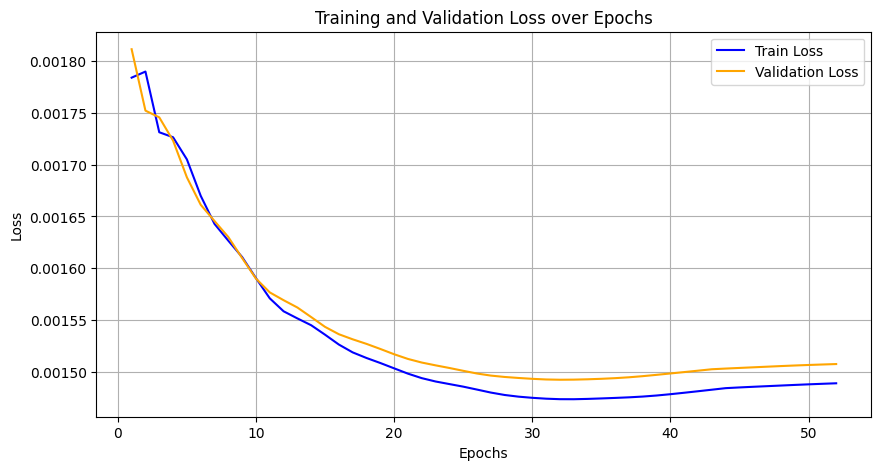

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

# Données d'entrée
features = features_tensor
adjacency = similarity_tensor_cosine

# Utilisation de torch_geometric pour gérer le graphe
edge_index, edge_weight = from_scipy_sparse_matrix(csr_matrix(adjacency))
data = Data(x=features, edge_index=edge_index, edge_attr=edge_weight)

# Division des données en ensembles d'entraînement et de validation
num_nodes = features.shape[0]
indices = np.arange(num_nodes)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

# Définition du modèle GCN-AE avec 3 couches et dropout
class GCN_AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, embedding_dim, output_dim, dropout=0.5):
        super(GCN_AE, self).__init__()
        self.encoder1 = GCNConv(input_dim, hidden_dim1)
        self.encoder2 = GCNConv(hidden_dim1, hidden_dim2)
        self.encoder3 = GCNConv(hidden_dim2, embedding_dim)
        self.embedding = GCNConv(embedding_dim, embedding_dim)
        self.decoder1 = GCNConv(embedding_dim, hidden_dim2)
        self.decoder2 = GCNConv(hidden_dim2, hidden_dim1)
        self.reconstructed = GCNConv(hidden_dim1, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        # Encoder
        x = self.encoder1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.encoder2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.encoder3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        embeddings = self.embedding(x, edge_index, edge_weight)
        # Decoder
        x = F.relu(embeddings)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.decoder1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.decoder2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.reconstructed(x, edge_index, edge_weight)
        return x, embeddings

# Création du modèle
input_dim = features.shape[1]
hidden_dim1 = 64
hidden_dim2 = 32
embedding_dim = 16
output_dim = input_dim  # La dimension de sortie est égale à la dimension d'entrée pour la reconstruction
dropout = 0.5

model = GCN_AE(input_dim, hidden_dim1, hidden_dim2, embedding_dim, output_dim, dropout)

# Entraînement du modèle
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Scheduler pour réduire le taux d'apprentissage
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-5)

# Listes pour enregistrer les pertes
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience_counter = 0
patience = 20  # Nombre d'époques pour l'arrêt précoce

def save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)
    print(f'Checkpoint saved at epoch {epoch + 1}')

def train():
    model.train()
    optimizer.zero_grad()
    reconstructed, embeddings = model(data)
    loss = F.mse_loss(reconstructed[data.train_mask], features[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        reconstructed, embeddings = model(data)
        loss = F.mse_loss(reconstructed[data.val_mask], features[data.val_mask])
    return loss.item()

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(200):  # Augmenter le nombre d'époques pour permettre une meilleure convergence
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, checkpoint_path)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Enregistrement des meilleures poids du modèle
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# Tracer les pertes d'entraînement et de validation avec courbes lissées
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Analyse des embeddings
model.eval()
with torch.no_grad():
    _, embeddings = model(data)
embeddings = embeddings.cpu().numpy()


In [ ]:
embeddings

array([[ 1.3439347e-03, -1.5097444e-03, -9.0485509e-04, ...,
        -1.4820873e-05,  4.5252856e-04, -7.8810233e-04],
       [ 1.3438618e-03, -1.5100170e-03, -9.0476417e-04, ...,
        -1.4998364e-05,  4.5226712e-04, -7.8810303e-04],
       [ 1.3427644e-03, -1.5141873e-03, -9.0337114e-04, ...,
        -1.7684046e-05,  4.4828674e-04, -7.8815600e-04],
       ...,
       [ 1.3432617e-03, -1.5122982e-03, -9.0400217e-04, ...,
        -1.6467200e-05,  4.5008998e-04, -7.8813237e-04],
       [ 1.3431531e-03, -1.5127088e-03, -9.0386509e-04, ...,
        -1.6732585e-05,  4.4969746e-04, -7.8813615e-04],
       [ 1.3436461e-03, -1.5108389e-03, -9.0448960e-04, ...,
        -1.5526697e-05,  4.5148330e-04, -7.8811485e-04]], dtype=float32)

In [ ]:

# Définir le chemin du fichier de checkpoint
checkpoint_path = '/content/checkpoints/checkpoint_epoch_50.pth'  # Mettez le chemin correct vers votre fichier de checkpoint

# Charger le checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Afficher les clés disponibles dans le checkpoint
print("Keys available in the checkpoint:")
print(checkpoint.keys())
print()

# Afficher des informations spécifiques du checkpoint
print("Information from the checkpoint:")
print(f"Epoch: {checkpoint['epoch']}")
print(f"Train Loss: {checkpoint['train_loss']}")
print(f"Validation Loss: {checkpoint['val_loss']}")



Keys available in the checkpoint:
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'val_loss'])

Information from the checkpoint:
Epoch: 49
Train Loss: 0.001487850327976048
Validation Loss: 0.0015065522165969014


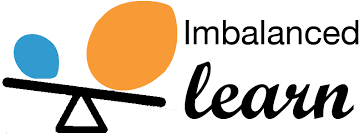

Sur-échantillonnage (Over-sampling) : Cette technique consiste à augmenter le nombre d'instances de la classe minoritaire en générant des échantillons synthétiques ou en répliquant des échantillons existants